In [2]:
item_nm = '무'

import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost.callback import EarlyStopping

# 1. 데이터 로드
df = pd.read_csv(f"EDA/{item_nm}_월차_작년평균단가포함.csv", encoding="cp949")
df = df.drop(columns=["등급코드"], errors="ignore")
df["week_start"] = pd.to_datetime(df["week_start"])
df = df.sort_values("week_start")

# 2. 주기 파생변수
df["week_sin"] = np.sin(2 * np.pi * df["week"] / 52)
df["week_cos"] = np.cos(2 * np.pi * df["week"] / 52)

# 3. 학습 데이터만 선택 (2024년까지)
df_train = df[df["year"] <= 2024].copy()

# 4. 파생변수 생성 (학습셋에서만)
group_cols = ["직팜산지코드"]
df_train["총거래량_lag1"] = df_train.groupby(group_cols)["총거래량(kg)"].shift(1)
df_train["총거래량_변화율"] = np.where(
    df_train["총거래량_lag1"] == 0,
    0,
    (df_train["총거래량(kg)"] - df_train["총거래량_lag1"]) / df_train["총거래량_lag1"]
)
df_train["평균단가_전년동주"] = df_train.groupby(group_cols)["평균단가(원)"].shift(52)
df_train["평균단가_전년비"] = (
    (df_train["평균단가(원)"] - df_train["평균단가_전년동주"]) / df_train["평균단가_전년동주"]
)

# 5. 사용 변수 정의
target_col = "평균단가(원)"
lag_features = [col for col in df.columns if "_t-" in col]  # 있을 경우 대비
derived_features = ["holiday_flag", "holiday_score", "grow_score"]
categorical_cols = ["품종코드"]
numeric_features = ["총거래량(kg)", "week_sin", "week_cos"]
change_features = ["총거래량_변화율", "평균단가_전년비"]
used_features = (
    numeric_features + lag_features + derived_features +
    categorical_cols + change_features + ["직팜산지코드", "year", "week", "week_start"]
)

In [3]:
# 6. 결측치 제거
df_train = df_train.dropna(subset=[target_col] + used_features).copy()

# 7. 인코딩
le = LabelEncoder()
df_train["직팜산지코드_le"] = le.fit_transform(df_train["직팜산지코드"])
df_train = pd.get_dummies(df_train, columns=["품종코드"])

# 8. 입력/출력 분리
X = df_train.drop(columns=[target_col, "year", "week", "week_start", "직팜산지코드"], errors="ignore")
y = df_train[target_col]

X = X.select_dtypes(include=[np.number]).astype(np.float32)

# 9. 학습/검증 분할 (시간순)
split_idx = int(len(X) * 0.8)
X_train = X.iloc[:split_idx]
X_val = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_val = y.iloc[split_idx:]

# 10. 스케일링
scale_cols = ["총거래량(kg)", "총거래량_변화율", "평균단가_전년비"]
scaler = ColumnTransformer(
    transformers=[("scaler", RobustScaler(), scale_cols)],
    remainder="passthrough",
    verbose_feature_names_out=False
)
pipe = Pipeline([("transform", scaler)])
X_train_scaled = pipe.fit_transform(X_train)
X_val_scaled = pipe.transform(X_val)

In [4]:
# 11. 모델 학습
model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=5,
    gamma=5,
    subsample=0.8,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)
model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_val_scaled, y_val)],
    callbacks=[EarlyStopping(rounds=30)],
    verbose=True
)

# 12. 검증 성능 출력
y_val_pred = model.predict(X_val_scaled)
print(f"✅ RMSE (val): {np.sqrt(mean_squared_error(y_val, y_val_pred)):.2f}")
print(f"✅ MAE (val): {mean_absolute_error(y_val, y_val_pred):.2f}")
print(f"✅ R² Score (val): {r2_score(y_val, y_val_pred):.4f}")

[0]	validation_0-rmse:706.79231
[1]	validation_0-rmse:673.89498
[2]	validation_0-rmse:642.51052
[3]	validation_0-rmse:612.76235
[4]	validation_0-rmse:584.26311
[5]	validation_0-rmse:564.41729
[6]	validation_0-rmse:547.72009
[7]	validation_0-rmse:522.78836


C:\Users\KOREA\anaconda3\envs\do_api_env\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-rmse:498.57203
[9]	validation_0-rmse:484.47345
[10]	validation_0-rmse:462.52051
[11]	validation_0-rmse:441.26674
[12]	validation_0-rmse:429.66697
[13]	validation_0-rmse:410.45727
[14]	validation_0-rmse:398.19966
[15]	validation_0-rmse:380.43857
[16]	validation_0-rmse:363.60694
[17]	validation_0-rmse:347.76216
[18]	validation_0-rmse:332.37911
[19]	validation_0-rmse:317.79567
[20]	validation_0-rmse:304.18948
[21]	validation_0-rmse:295.74027
[22]	validation_0-rmse:283.12290
[23]	validation_0-rmse:270.93389
[24]	validation_0-rmse:259.37026
[25]	validation_0-rmse:248.43143
[26]	validation_0-rmse:238.17082
[27]	validation_0-rmse:232.84139
[28]	validation_0-rmse:223.38477
[29]	validation_0-rmse:214.29625
[30]	validation_0-rmse:205.40425
[31]	validation_0-rmse:197.16926
[32]	validation_0-rmse:189.20270
[33]	validation_0-rmse:181.64576
[34]	validation_0-rmse:174.43858
[35]	validation_0-rmse:167.59718
[36]	validation_0-rmse:161.13760
[37]	validation_0-rmse:158.19041
[38]	validat

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 한글 폰트 설정
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# ✅ 1. 테스트셋 파생변수 생성을 위해 2024~2025년 데이터 사용
df_test_base = df[df["year"] >= 2024].copy()
group_cols = ["직팜산지코드"]

# ✅ 2. 파생변수 생성
df_test_base["총거래량_lag1"] = df_test_base.groupby(group_cols)["총거래량(kg)"].shift(1)
df_test_base["총거래량_변화율"] = np.where(
    df_test_base["총거래량_lag1"] == 0,
    0,
    (df_test_base["총거래량(kg)"] - df_test_base["총거래량_lag1"]) / df_test_base["총거래량_lag1"]
)
df_test_base["평균단가_전년동주"] = df_test_base.groupby(group_cols)["평균단가(원)"].shift(52)
df_test_base["평균단가_전년비"] = (
    (df_test_base["평균단가(원)"] - df_test_base["평균단가_전년동주"]) / df_test_base["평균단가_전년동주"]
)

# ✅ 3. 2025년 데이터만 추출
df_test = df_test_base[df_test_base["year"] == 2025].copy()

# ✅ 4. 결측치 제거
df_test = df_test.dropna(subset=["평균단가(원)", "총거래량(kg)", "총거래량_변화율", "평균단가_전년비"]).copy()

# ✅ 5. 정답값 분리
y_test = df_test["평균단가(원)"].copy()

# ✅ 6. Label Encoding (직팜산지코드)
known_codes = set(le.classes_)
df_test = df_test[df_test["직팜산지코드"].isin(known_codes)].copy()
y_test = y_test.loc[df_test.index]
df_test["직팜산지코드_le"] = le.transform(df_test["직팜산지코드"])

# ✅ 7. 원핫인코딩 (품종코드)
df_test = pd.get_dummies(df_test, columns=["품종코드"])

# ✅ 8. 누락된 품종코드 컬럼 채우기
missing_cols = [col for col in X_train.columns if col not in df_test.columns and col.startswith("품종코드_")]
for col in missing_cols:
    df_test[col] = 0

# ✅ 9. 입력 데이터 구성
X_test = df_test.drop(columns=["year", "week", "week_start", "직팜산지코드", "평균단가(원)"], errors="ignore")
X_test = X_test.select_dtypes(include=[np.number]).astype(np.float32)

# ✅ 10. 컬럼 순서 맞추기
X_test = X_test[X_train.columns]

# ✅ 11. 스케일링 적용
X_test_scaled = pipe.transform(X_test)

# ✅ 12. 예측
y_pred = model.predict(X_test_scaled)

# ✅ 13. 성능 평가
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("📊 2025년 테스트셋 성능:")
print(f"✅ RMSE (test): {rmse:.2f}")
print(f"✅ MAE  (test): {mae:.2f}")
print(f"✅ R²   (test): {r2:.4f}")

📊 2025년 테스트셋 성능:
✅ RMSE (test): 43.06
✅ MAE  (test): 29.23
✅ R²   (test): 0.9881


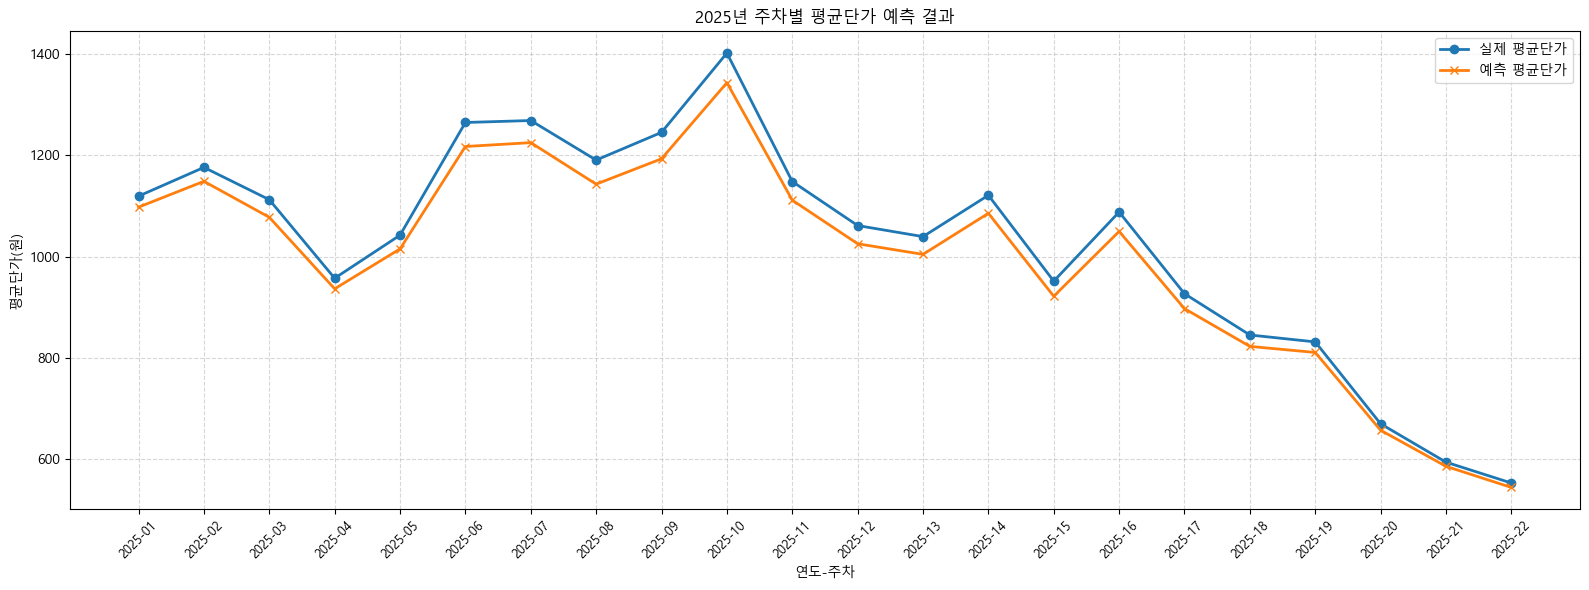

In [7]:
# ✅ 9. 시각화용 데이터 구성
plot_df = df_test.copy()
plot_df = plot_df.reset_index(drop=True)
plot_df["실제값"] = y_test.reset_index(drop=True)
plot_df["예측값"] = y_pred
plot_df["year"] = plot_df["year"].astype(int)
plot_df["week"] = plot_df["week"].astype(int)

# ✅ 10. 주차별 평균 집계
weekly_avg = (
    plot_df.groupby(["year", "week"])[["실제값", "예측값"]]
    .mean()
    .reset_index()
)
weekly_avg["연도_주차"] = (
    weekly_avg["year"].astype(str) + "-" + weekly_avg["week"].astype(str).str.zfill(2)
)

# ✅ 11. 시각화
plt.figure(figsize=(16, 6))
plt.plot(weekly_avg["연도_주차"], weekly_avg["실제값"], label="실제 평균단가", marker="o", linewidth=2)
plt.plot(weekly_avg["연도_주차"], weekly_avg["예측값"], label="예측 평균단가", marker="x", linewidth=2)
plt.title("2025년 주차별 평균단가 예측 결과")
plt.xlabel("연도-주차")
plt.ylabel("평균단가(원)")
plt.xticks(rotation=45, fontsize=9)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()